In [2]:
import argparse
import json
import logging
import os
import random
import time

import torch
import numpy as np

In [3]:
import sys 
sys.path.append('..')
import utils.misc as ws
import utils.data_utils
import utils.train_utils
import utils.eval_utils
import utils.mesh
import utils.dataset as d
import models.networks as arch


In [11]:
DATA_SOURCE = '/home/ninad/Desktop/Docs/phd-res/proj-irvl-grasp-transfer/code/docker-data/output_dataset/'
EXPERIMENTS_DIR = '../experiments/epochs_2000_weight_0.5/'
# EXPERIMENTS_DIR = '../experiments/epochs_3000_weight_0.8/'
CHECKPOINT = 'latest'
split_filename = '../split_train.json'
specs_filename = os.path.join(EXPERIMENTS_DIR, "specs.json")

LATENT_CODE_DIR = ws.latent_codes_subdir

In [14]:
object_model = '003_cracker_box_google_16k_textured_scale_1000'
gripper_name = 'fetch_gripper'
grasp_fpath = os.path.join(DATA_SOURCE, 'refined_grasps', f'refined_{object_model}-{gripper_name}.json')

with open(grasp_fpath, "r") as gf:
    all_grasp_data = json.load(gf)

In [82]:
grasp_data = all_grasp_data['grasps']
print(len(grasp_data))


# Only pick out the training poses
# For us, its the first 40 poses.
trn_poses_num = 40
grasp_poses = [indiv_grasp['pose'] for indiv_grasp in grasp_data[:trn_poses_num]]

print(len(grasp_poses))

50
40


In [83]:
from scipy.spatial.transform import Rotation
from scipy.spatial.distance import pdist, cdist

def get_euler_from_quat(quat):
    rot = Rotation.from_quat(quat)
    return rot.as_euler('xyz')

def get_6d_pose(pose_7d):
    return pose_7d[:3] + list(get_euler_from_quat(pose_7d[3:]))

poses_6d = [get_6d_pose(pose) for pose in grasp_poses]

In [84]:
print(len(poses_6d))
# its a list of lists
# make it numpy friendly
poses_6d = np.array(poses_6d)
print(poses_6d.shape)
print(poses_6d[0])

40
(40, 6)
[-0.00876582 -0.00328555 -0.13743711  1.06170688 -1.5414356  -2.62369915]


In [103]:
# Mask the (self) idx and then take argmin / argsort

def get_argmin_ignore_self(mat, idx):
    tmp_vec = np.ma.array(mat[idx])
    tmp_vec[idx] = np.ma.masked
    # ignore last entry as its equalt to idx
    return tmp_vec.argmin()

def get_argsort_ignore_self(mat, idx):
    tmp_vec = np.ma.array(mat[idx])
    tmp_vec[idx] = np.ma.masked
    # ignore last entry as its equalt to idx
    return tmp_vec.argsort()[:-1]

In [124]:
pose_closest = [get_argmin_ignore_self(cdist(poses_6d, poses_6d), i) for i in range(poses_6d.shape[0])]
pose_closest_idxs = [get_argsort_ignore_self(cdist(poses_6d, poses_6d), i) for i in range(poses_6d.shape[0])]

In [125]:
print(pose_closest[0])

print(pose_closest_idxs[0])


19
[19 32 33 10 16  4 31 30  2 22  9 20 17 28 24 21 39  6  3 26  8 37 35 18
 38  7 14 23 11 12 13 25 15  5 36 34 27 29  1]


In [88]:
specs = json.load(open(specs_filename))
latent_size = specs["CodeLength"]
gripper_weight = specs["GripperWeight"]

In [6]:
# decoder = arch.dsdfDecoder(latent_size, **specs["NetworkSpecs"])

# decoder = torch.nn.DataParallel(decoder)

# saved_model_state = torch.load(
#     os.path.join(
#         EXPERIMENTS_DIR, ws.model_params_subdir, CHECKPOINT + ".pth")
# )

# saved_model_epoch = saved_model_state["epoch"]

# decoder.load_state_dict(saved_model_state["model_state_dict"])

# decoder = decoder.module.cuda()

In [89]:
with open(split_filename, "r") as f:
    split = json.load(f)

# npz_filenames = utils.data_utils.dsdf_get_instance_filenames(
#     args.data_source, split)
npz_filenames = utils.data_utils.get_instance_filelist(DATA_SOURCE, split)

# random.shuffle(npz_filenames) # WHY??? DISABLE THIS FOR CHECKING REPRODUCIBILITY

In [90]:
for f in npz_filenames:
    print(f[-15:])

_graspnum_0.npz
_graspnum_1.npz
_graspnum_2.npz
_graspnum_3.npz
_graspnum_4.npz
_graspnum_5.npz
_graspnum_6.npz
_graspnum_7.npz
_graspnum_8.npz
_graspnum_9.npz
graspnum_10.npz
graspnum_11.npz
graspnum_12.npz
graspnum_13.npz
graspnum_14.npz
graspnum_15.npz
graspnum_16.npz
graspnum_17.npz
graspnum_18.npz
graspnum_19.npz
graspnum_20.npz
graspnum_21.npz
graspnum_22.npz
graspnum_23.npz
graspnum_24.npz
graspnum_25.npz
graspnum_26.npz
graspnum_27.npz
graspnum_28.npz
graspnum_29.npz
graspnum_30.npz
graspnum_31.npz
graspnum_32.npz
graspnum_33.npz
graspnum_34.npz
graspnum_35.npz
graspnum_36.npz
graspnum_37.npz
graspnum_38.npz
graspnum_39.npz


In [91]:
latent_vecs = ws.load_latent_vectors(EXPERIMENTS_DIR, CHECKPOINT)
print(latent_vecs.shape)

torch.Size([40, 256])


In [92]:
lv_numpy = latent_vecs.cpu().numpy()

In [93]:
lv_numpy.shape

(40, 256)

In [126]:
lv_closest = np.array([get_argmin_ignore_self(cdist(lv_numpy, lv_numpy), i) for i in range(lv_numpy.shape[0])])
lv_closest_idxs = np.array([get_argsort_ignore_self(cdist(lv_numpy, lv_numpy), i) for i in range(lv_numpy.shape[0])])

In [127]:
target_idx = 2

print(pose_closest_idxs[target_idx])

print(lv_closest_idxs[target_idx])

[30 17  9 19  0 33 32 23 31 16  4 22 13 10 38 11 20 35  7 27 25 14 15  3
 24 26 36 34  6 39 18  8 37  5 12 21 29 28  1]
[12 37 18  5  8 36 31 29  9 16  1 17 32 33 38 15 34  4 39 10 21  0 20 30
 19 35 25  7 26 28 27 22  3 23 14 11  6 24 13]


In [139]:
sum(pose_closest == lv_closest)

3

In [151]:
def count_topk(queries, target_idxs, k):
    return sum([val in target_idxs[i][:k] for i, val in enumerate(queries)])

In [150]:
print('check if the closest pose is in the top-k closest latent vectors')
print(count_topk(pose_closest, lv_closest_idxs, 3))
print(count_topk(pose_closest, lv_closest_idxs, 5))
print(count_topk(pose_closest, lv_closest_idxs, 10))

print('\n')
# Now do the opposite!
print('check if the closest lv is in the top-k closest poses')
print(count_topk(lv_closest, pose_closest_idxs, 3))
print(count_topk(lv_closest, pose_closest_idxs, 5))
print(count_topk(lv_closest, pose_closest_idxs, 10))

check if the closest pose is in the top-k closest latent vectors
8
16
29


check if the closest lv is in the top-k closest poses
15
20
23


In [10]:
index_to_select = random.randint(0, len(npz_filenames)-1)

npz = npz_filenames[index_to_select]

full_filename = npz

print(index_to_select, npz[-15:])


29 graspnum_29.npz


In [11]:
latent_vec = latent_vecs[index_to_select]

In [12]:
latent_vec = latent_vec.squeeze()
print(latent_vec.shape)

torch.Size([256])


In [13]:
####### MESH RECONSTRUCTION CODE!

is_gripper = True

if is_gripper:
    mesh_filename = os.path.join(EXPERIMENTS_DIR, f'test_{npz[-15:]}')
else:
    mesh_filename = os.path.join(EXPERIMENTS_DIR, f'test_o_{npz[-15:]}')


latent_vec = latent_vec.squeeze().cuda()
with torch.no_grad():
    utils.mesh.create_mesh_custom(
        decoder, latent_vec, mesh_filename, N=256, max_batch=int(2 ** 18), isGripper=is_gripper)


sampling takes: 11.106714


In [14]:
# IMPORTANT: HAVE SHUFFLE = FALSE SO THAT SAME DATA POINT IS LOADED AS index_to_select

sdf_dataset = d.SDFSamples(DATA_SOURCE, split, 1000000)

sdf_loader = torch.utils.data.DataLoader(
    sdf_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    drop_last=True )

In [15]:
# samples, npzfile = next(iter(sdf_loader))
samples, idx, npzfile = sdf_dataset[index_to_select]
print(npzfile[-40:])

queries = samples[:, :3] # Need to pass this through the network
gt_sdf_obj = samples[:, 3].squeeze().numpy()
gt_sdf_grp = samples[:, 4].squeeze().numpy()
print(gt_sdf_grp.shape)

00/sdf/fetch_gripper/sdf_graspnum_29.npz
(1000000,)


In [15]:
print(samples.shape)

torch.Size([1000000, 5])


In [16]:
with torch.no_grad():
    queries, sdf_obj, sdf_grp = utils.eval_utils.eval_query_pc(decoder, latent_vec.cuda(), queries)

In [17]:
queries = queries.detach().cpu().numpy()
sdf_obj = sdf_obj.detach().cpu().numpy()
sdf_grp = sdf_grp.detach().cpu().numpy()

In [18]:
print(sdf_grp.shape)
print(sdf_obj.shape)
print(queries.shape)

(1000000,)
(1000000,)
(1000000, 3)


In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def plot_sdf(xyz, sdf, title='Sample_Title', n_display=10000):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')    

    ind = np.random.choice(range(xyz.shape[0]), n_display)
    data = xyz[ind].T

    ax.scatter(data[0], data[2], data[1], s=5, c=sdf[ind])
    ax.view_init(20, 100)
    limit = (-0.95, 0.95)
    ax.set_xlim3d(*limit)
    ax.set_ylim3d(*limit)
    ax.set_zlim3d(*limit)
    plt.title(title)
    plt.show()

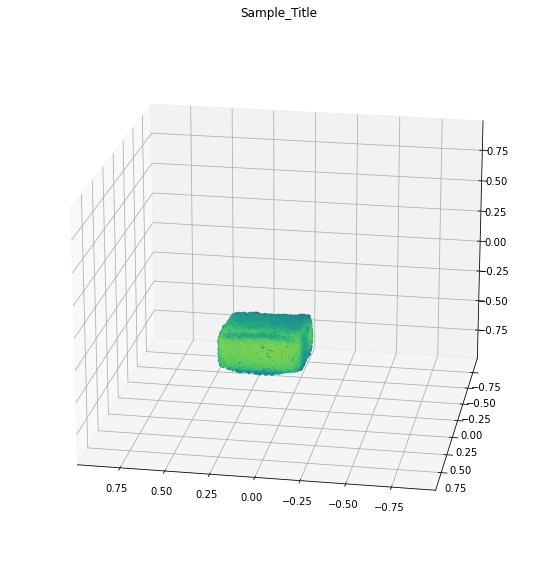

-0.0004404727

In [22]:
EPS = -1e-4
# ind_obj =  np.where((y >= -EPS) & (y <= EPS))
ind_grp = sdf_grp <= EPS

plot_sdf(queries[ind_grp], sdf_obj[ind_grp])

min(sdf_grp)

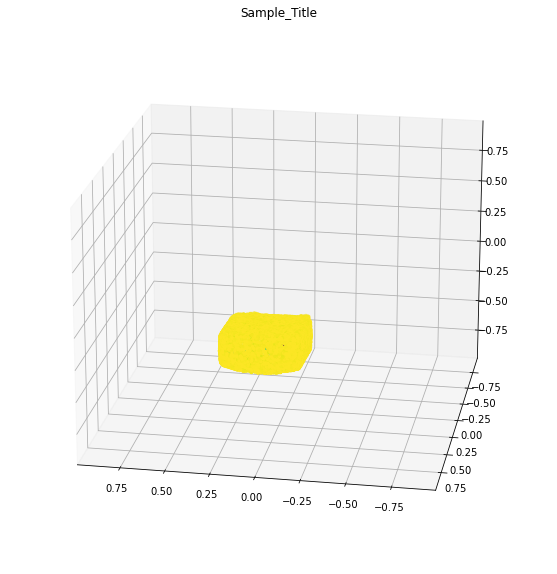

-0.12474868

In [23]:
EPS = -1e-4
# ind_obj =  np.where((y >= -EPS) & (y <= EPS))
ind_grp = gt_sdf_grp <= EPS

plot_sdf(queries[ind_grp], gt_sdf_grp[ind_grp])

min(gt_sdf_obj)

In [24]:
import pyrender
# Just pass the points you want to visualize
def plt_points_3d(pts):
    colors = np.zeros(pts.shape)
    cloud = pyrender.Mesh.from_points(pts, colors=colors)
    scene = pyrender.Scene()
    scene.add(cloud)
    viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)

# Pass the point as well as the sdf to see inside/outside points
def plt_points_sdf(pts, sdf, eps=1e-4):
    colors = np.zeros(pts.shape)
    colors[sdf < eps, 1] = 1
    colors[sdf > eps, 0] = 1
    cloud = pyrender.Mesh.from_points(pts, colors=colors)
    scene = pyrender.Scene()
    scene.add(cloud)
    viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)

def plt_points_sdf_compare(pts, sdf_gt, sdf_pred):
    colors = np.zeros(pts.shape)
    colors[sdf_gt < 0, 1] = 1
    colors[sdf_gt > 0, 0] = 1
    cloud = pyrender.Mesh.from_points(pts, colors=colors)
    scene = pyrender.Scene()
    scene.add(cloud)
    viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)
    
    colors2 = np.zeros(pts.shape)
    colors2[sdf_pred < 0, 1] = 1
    colors2[sdf_pred > 0, 0] = 1
    cloud2 = pyrender.Mesh.from_points(pts, colors=colors2)
    scene2 = pyrender.Scene()
    scene2.add(cloud2)
    viewer = pyrender.Viewer(scene2, use_raymond_lighting=True, point_size=2)

In [27]:
plt_points_3d(queries[sdf_grp < 1e-4])

In [30]:
plt_points_3d(queries[sdf_obj < 1e-1])

In [31]:
plt_points_sdf(queries, sdf_grp)

In [32]:
plt_points_sdf(queries, sdf_obj)